# Adult Census Data

**Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.**

### Data Information
- Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
- Prediction task is to determine whether a person makes over 50K a year.

### Attribute Information
- Listing of attributes: >50K, <=50K.

- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

URL: https://archive.ics.uci.edu/ml/datasets/adult

<hr style="border:3px solid black">

In [100]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math

import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')

As one of our objectives is to implement ML technique which take advantage of parallelisation, we opted for neural networks with help of Tensorflow. TensorFlow provides strong support for distributing deep learning across multiple CPUs and GPUs. Cloud platforms like Google Colab and Kaggle provide GPU and CPU resources which can be used for this project. The code below shows how we can check for the physical devices (resources) available to us for our usage. By selecting a particular device, we include a piece of tensorflow code before compiling and fitting our neural network model to allow usage of this selected device. Selecting CPU will only allow access to CPU device available, but selecting GPU will allow access to CPU + GPU devices. Multiple GPUs can also be used, but since our amount of data is not large and our ML models being less complex, single GPU is sufficient.

In [101]:
print("Checking for physical Tensorflow or GPU devices -->")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

Checking for physical Tensorflow or GPU devices -->
: /physical_device:CPU:0
: /physical_device:GPU:0
: /physical_device:GPU:1


In [102]:
# Set the GPU/TPU device name
#SET_DEVICE = 'CPU:0'
SET_DEVICE = 'GPU:0'

<hr style="border:3px solid black">

## Data Exploration and Pre-Processing

In [103]:
# change the input path if running from local
# input_start_path = '/kaggle/input/incomedata/'
# if local same folder uncomment following
# input_start_path = './'
url_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/'

columnNames = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race',
              'sex','capital-gain','capital-loss','hours-per-week','native-country','class']

adult_df = pd.read_csv(url_path+'adult.data', names=columnNames, header=None, sep=', ',engine='python')
adult_df_test = pd.read_csv(url_path+'adult.test', header=None,names=columnNames, skiprows=1,sep=', ',engine='python')

**Observation 1: While importing the data, we can note that even though the data is available in a csv file, the entities are not entirely seperated by commas but rather seperated with comma followed by space.**
<hr style="border:3px solid black">

In [104]:
# Train data
adult_df.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [105]:
# Test data
adult_df_test.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.


**Observation 2: As we can see the target/class values in test data set ends with a period unlike thoes in training set.**

In [106]:
# class values in test file ends with '.' hence cleaning reqired
adult_df_test[['class','noise']] = adult_df_test['class'].str.split('.',expand=True)
adult_df_test = adult_df_test.drop(columns=['noise'])

<hr style="border:3px solid black">

In [107]:
# Dimensions
print("Train: {}, Test:{}".format(adult_df.shape,adult_df_test.shape))

Train: (32561, 15), Test:(16281, 15)


In [108]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [109]:
adult_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16281 non-null  object
 14  class           16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


<hr style="border:3px solid black">

In [110]:
# Missing values - '?'
adult_df = adult_df.replace('?',math.nan)
adult_df_test = adult_df_test.replace('?',math.nan)


**Observation 3: Missing values in the original data set are present as '?'. So we create data by replacing missing with nan values**

In [111]:
# Missing values
print("Train Data total missing values observed in --")
print(adult_df.isna().sum()[adult_df.isna().sum()>0])

print("\nTest Data total missing values observed in --")
print(adult_df_test.isna().sum()[adult_df.isna().sum()>0])

print("Shape: Train: {}, Test:{}".format(adult_df.shape,adult_df_test.shape))

Train Data total missing values observed in --
workclass         1836
occupation        1843
native-country     583
dtype: int64

Test Data total missing values observed in --
workclass         963
occupation        966
native-country    274
dtype: int64
Shape: Train: (32561, 15), Test:(16281, 15)


<hr style="border:3px solid black">

In [1]:
# Utility functions

# Dropping the Null value rows from train and test
def drop_null(df,df_test):
    print(" Shape Before: Train: {}, Test:{}".format(df.shape,df_test.shape))
    df = df.dropna()
    df_test = df_test.dropna()
    print(" Shape After: Train: {}, Test:{}".format(df.shape,df_test.shape))
    return df,df_test

# Dropping same columns from train and test
def drop_cols(df,df_test,_list):
    print(" Shape Before: Train: {}, Test:{}".format(df.shape,df_test.shape))
    df = df.drop(columns=_list)
    df_test = df_test.drop(columns=_list)
    print(" Shape After: Train: {}, Test:{}".format(df.shape,df_test.shape))
    return df,df_test

# Plot count of classes in a feature
def count_plot(df,col_name,title="",fig_height =15, fig_width =12, save_fig_name=None, subplot_row=2, subplot_col=1, subplot_num=1):
    fig = plt.figure(figsize=(fig_width,fig_height))
    plt.subplot(subplot_row, subplot_col, subplot_num)
    plt.title(title)
    ax = sns.countplot(data=df,  y=col_name)
    total = len(df[col_name])
    for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    
    if(save_fig_name == None):
        return plt
    else:
        plt.savefig(save_fig_name+".png")
        return plt
    
# plot count of data point in features w.r.t class >50k and <=50k
def class_plot(df,feature,title="", save_fig_name=None):
    d = df[[feature,'class']]
    d.groupby('class')[feature].value_counts().unstack(0).plot.barh()
    plt.title(title)
    if(save_fig_name == None):
        return plt
    else:
        plt.savefig(save_fig_name+".png")
        return plt

<hr style="border:3px solid black">

In [113]:
adult_df.groupby(['education','education-num','class'])['class'].count()

education     education-num  class
10th          6              <=50K     871
                             >50K       62
11th          7              <=50K    1115
                             >50K       60
12th          8              <=50K     400
                             >50K       33
1st-4th       2              <=50K     162
                             >50K        6
5th-6th       3              <=50K     317
                             >50K       16
7th-8th       4              <=50K     606
                             >50K       40
9th           5              <=50K     487
                             >50K       27
Assoc-acdm    12             <=50K     802
                             >50K      265
Assoc-voc     11             <=50K    1021
                             >50K      361
Bachelors     13             <=50K    3134
                             >50K     2221
Doctorate     16             <=50K     107
                             >50K      306
HS-grad       9    

**Observation 4: education and education-num feature represent same information hence one column can be removed**

In [114]:
# removing educaion
_list = ['education']
adult_df,adult_df_test = drop_cols(adult_df,adult_df_test,_list)

 Shape Before: Train: (32561, 15), Test:(16281, 15)
 Shape After: Train: (32561, 14), Test:(16281, 14)


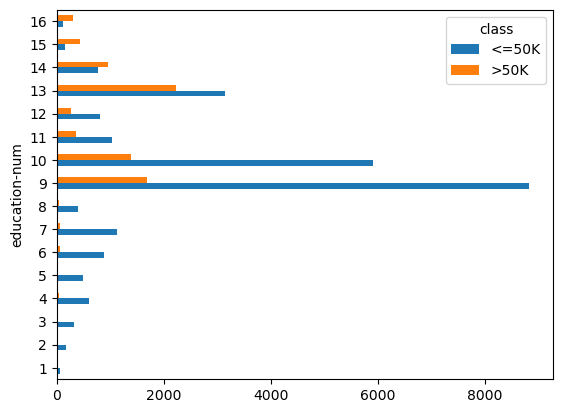

In [115]:
class_plot(adult_df,'education-num').show()

**We have 16 levels of eduatcation categories, due to imbalance in dataset, once option can be to minimise the existing categories. So grouping the 16 categories into 4 categories with each category with max of 5 levels**
- education-num 0-5 -> 0
- 6-10 -> 1
- 11-15 -> 2
- 16 -> 3

About the relationship between feature education and income: 

- 1675 out of 8826 of people with H-S GRADE make more than 50k.

- A small proportion of people with a college degree make more than 50k. 

- 2221 out of 3134 of people with bachelors make over 50K.

This indicates that people with higher education tend to make >= 50k

In [116]:
# Minimising the existing categories for education-num feature.
adult_df.loc[adult_df['education-num']<=5, 'education-num'] = 0
adult_df.loc[(adult_df['education-num']<=10) & (adult_df['education-num']>5), 'education-num'] = 1
adult_df.loc[(adult_df['education-num']<=15) & (adult_df['education-num']>10), 'education-num'] = 2
adult_df.loc[(adult_df['education-num']<=20) & (adult_df['education-num']>15), 'education-num'] = 3

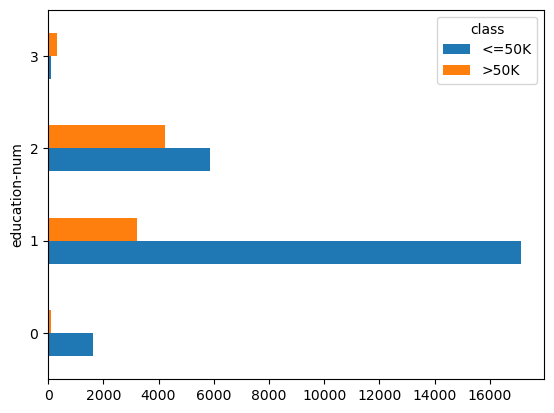

In [117]:
adult_df = adult_df.astype({'education-num': 'object'})
# After creating the variables
class_plot(adult_df,'education-num').show()

In [118]:
# Test Set
adult_df_test.loc[adult_df_test['education-num']<=5, 'education-num'] = 0
adult_df_test.loc[(adult_df_test['education-num']<=10) & (adult_df_test['education-num']>5), 'education-num'] = 1
adult_df_test.loc[(adult_df_test['education-num']<=15) & (adult_df_test['education-num']>10), 'education-num'] = 2
adult_df_test.loc[(adult_df_test['education-num']<=20) & (adult_df_test['education-num']>15), 'education-num'] = 3
adult_df_test = adult_df_test.astype({'education-num': 'object'})

<hr style="border:3px solid black">

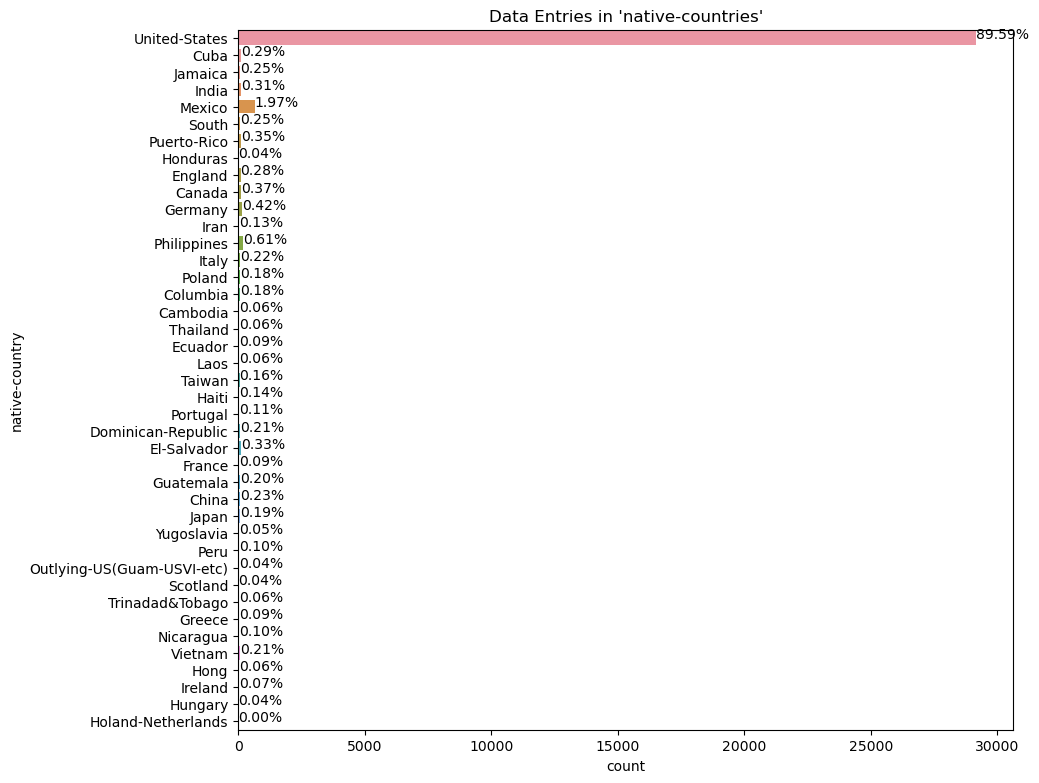

In [119]:
# Native country 
count_plot(adult_df,"native-country",title="Data Entries in 'native-countries'",fig_height=20,fig_width=10).show()

**Observation 5: As we can see the the feature 'native-country is significantly umbalanced with maximum data points (90%) from USA. Similar pattern seen in test data as well. Hence dropping this redundant column deemed ideal**

In [120]:
# Dropping Native Country
_list = ['native-country']
adult_df,adult_df_test = drop_cols(adult_df,adult_df_test,_list)

 Shape Before: Train: (32561, 14), Test:(16281, 14)
 Shape After: Train: (32561, 13), Test:(16281, 13)


<hr style="border:3px solid black">

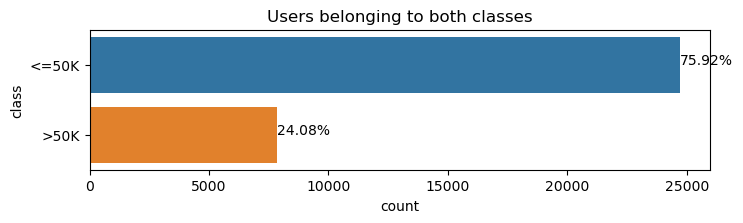

In [121]:
# Users belonging to both classes
count_plot(adult_df,"class",title="Users belonging to both classes",fig_height=4,fig_width=8).show()

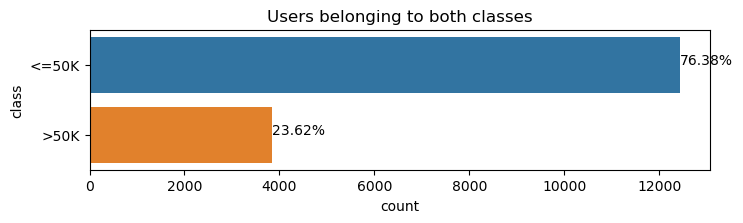

In [122]:
count_plot(adult_df_test,"class",title="Users belonging to both classes",fig_height=4,fig_width=8).show()

**Observation 6: Majority of users in the training as well as test data set belongs to the class with income less that or equal to 50,000 USD**

In [123]:
# Before further exploration we drop the missing values
adult_df,adult_df_test = drop_null(adult_df,adult_df_test)

 Shape Before: Train: (32561, 13), Test:(16281, 13)
 Shape After: Train: (30718, 13), Test:(15315, 13)


<hr style="border:3px solid black">

### Some further observations with visualisations on the available feature w.r.t class labels as well as pre-processing tasks on few features  as follows:

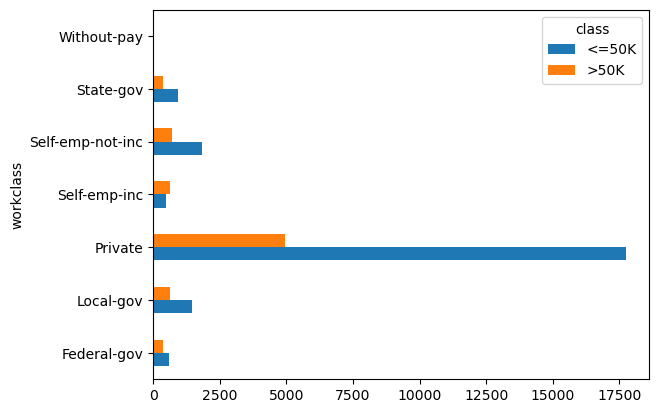

In [124]:
# Feature - workclass
class_plot(adult_df,'workclass').show()

- As we can see most of the users belong to private work class with majority having income less than 50K. Other features may help people from the private sector to make more than 50k a year.


- A small proportion of people from the other sectors make over 50k a year



Also we can see similar situation of imbalance w.r.t each category. Here we opt for making 2 categories w.r.t government, gov and non-gov**
- Private, Self-emp-not-inc, Self-emp-inc, Without-pay -> Non-Gov
- State-gov, Federal-gov, Local-gov -> Gov

In [125]:
# 'Non-Gov'
# 'Gov'
# Minimise the categories in the workclass feature
def convert_workclass(df):
    df.loc[(df['workclass']=='Private') | (df['workclass']=='Self-emp-not-inc') | 
           (df['workclass']=='Self-emp-inc') | (df['workclass']=='Without-pay'), 'workclass'] = 'Non-Gov'
    df.loc[(df['workclass']=='State-gov') | (df['workclass']=='Federal-gov') | 
           (df['workclass']=='Local-gov'), 'workclass'] = 'Gov'
    
    
    return df.astype({'workclass': 'object'})

adult_df = convert_workclass(adult_df)
adult_df_test = convert_workclass(adult_df_test)

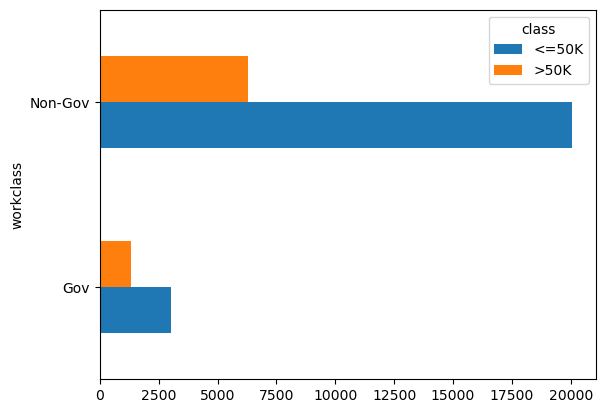

In [127]:
#  After minimising category
class_plot(adult_df,'workclass').show()

<hr style="border:3px solid black">

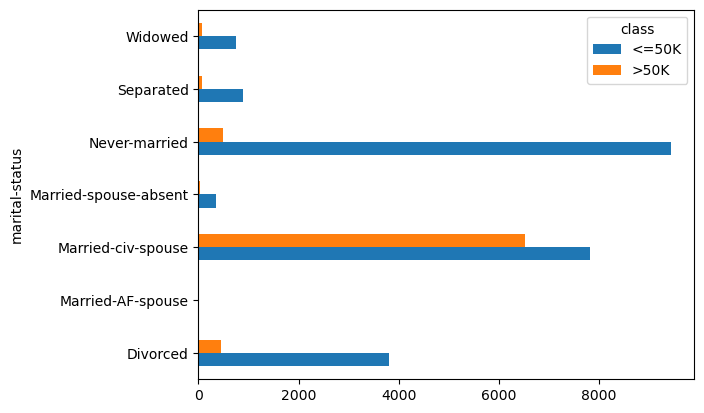

In [128]:
# Feature - marital-status
class_plot(adult_df,'marital-status').show()

- We  see that people with civilian spouse or with a spouse in the armed forces are more likely to make more than 50K a year. 

**We can minimise the categories with married (with spouse present) and non-married or single**
- 'Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-spouse-absent' -> single
- 'Married-civ-spouse', 'Married-AF-spouse' -> Married



In [129]:
# 'Single'
# 'Married'
# Minimisig the marital status categories
def convert_marital_status(df):
    df.loc[(df['marital-status']=='Never-married') | (df['marital-status']=='Divorced') | 
           (df['marital-status']=='Married-spouse-absent') | (df['marital-status']=='Separated') | (df['marital-status']=='Widowed'), 'marital-status'] = 'Single'
    df.loc[(df['marital-status']=='Married-civ-spouse') | (df['marital-status']=='Married-AF-spouse'), 'marital-status'] = 'Married'
    
    
    return df.astype({'marital-status': 'object'})

adult_df = convert_marital_status(adult_df)
adult_df_test = convert_marital_status(adult_df_test)

In [ ]:
#  After minimising category
class_plot(adult_df,'marital-status').show()

<hr style="border:3px solid black">

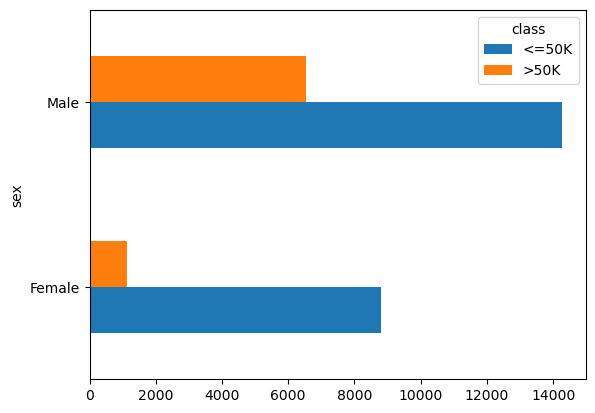

In [131]:
# Feature - sex
class_plot(adult_df,'sex').show()

The dataset contains mainly male, we observe also that men are more likely to make over 50k. 

<hr style="border:3px solid black">

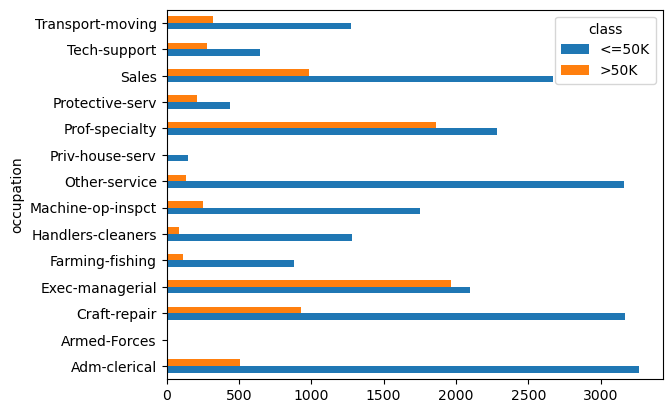

In [132]:
# Feature - Occupation
class_plot(adult_df,'occupation').show()

- As we can see the occupation category can't be minimised.

- people with professional specialty occupation are more likely to make over when compared to other categories 

- Feature education, workclass and occupation are possibly related, i.e higher education can lead to more specialized jobs, which can help with the income.

<hr style="border:3px solid black">

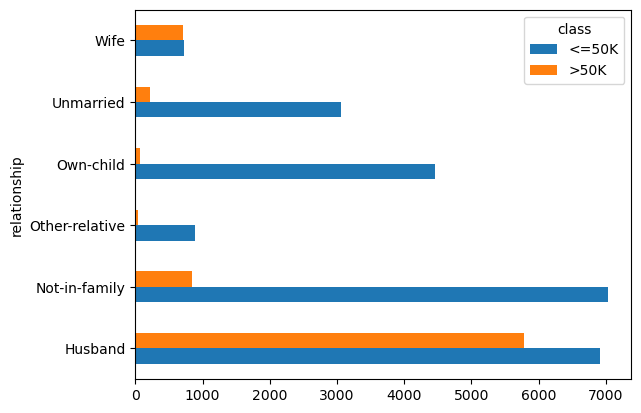

In [133]:
# Feature - Husband
class_plot(adult_df,'relationship').show()

- Similar to occupation, categories in relationship feature were also not minimised

- People which are husbands or wives are more likely to make more than 50k. this goes in line with the marital status observation, where people with civilian spouse or in the armed forces are more likely to make over 50k compared to others.

<hr style="border:3px solid black">

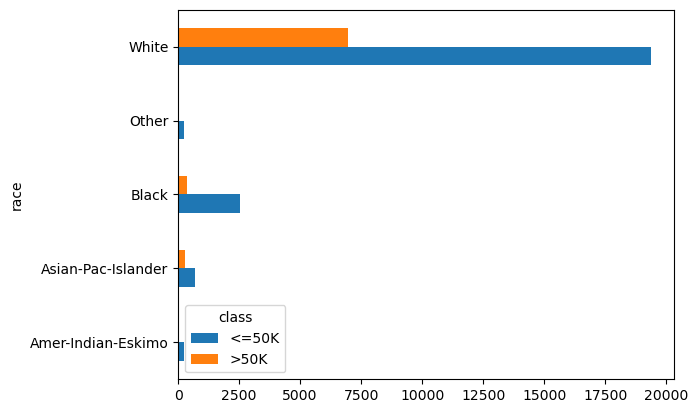

In [134]:
# Feature: Race
class_plot(adult_df,'race').show()

- Seen the high number of white people, it is not possible to distinguish a clear trend on income for the race feature.

- We can see the imbalance in the data set w.r.t race as majority of user here belong to 'White'. We can try to group the rest of the categories into non-white

'White' -> White

'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other' -> Non-White

In [135]:
# Minimising the categories in race feature
def convert_race(df):
    df.loc[(df['race']=='Black') | (df['race']=='Asian-Pac-Islander') | 
           (df['race']=='Amer-Indian-Eskimo') | (df['race']=='Other'), 'race'] = 'Non-White'
    df.loc[(df['race']=='White'), 'race'] = 'White'
    
    
    return df.astype({'race': 'object'})

adult_df = convert_race(adult_df)
adult_df_test = convert_race(adult_df_test)

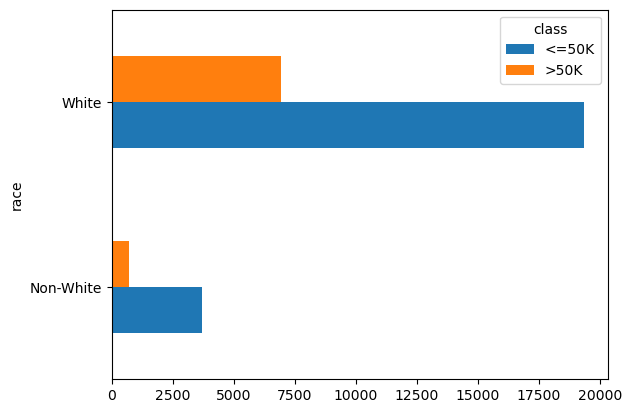

In [136]:
#  After minimising category
class_plot(adult_df,'race').show()

**The 'race' feature is likely to be less useful due to the imbalance**

<hr style="border:3px solid black">

In [137]:
# Converting th class column to binary 1-0
# <=50K -> 0
# >50K -> 1
adult_df['class'].replace({'<=50K':0,'>50K':1},inplace=True)
adult_df_test['class'].replace({'<=50K':0,'>50K':1},inplace=True)

adult_df.head(2)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,class
0,39,Gov,77516,2,Single,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Non-Gov,83311,2,Married,Exec-managerial,Husband,White,Male,0,0,13,0


<hr style="border:3px solid black">

### Checking the numeric variables

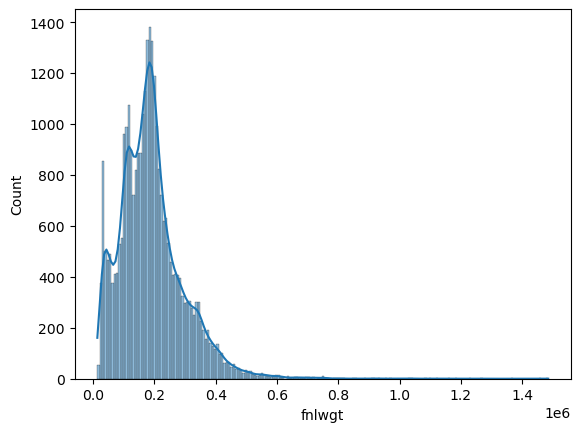

In [138]:
# Feature - fnlwgt
# Highly skewed
sns.histplot(data = adult_df,x = 'fnlwgt', kde=True)
plt.show()

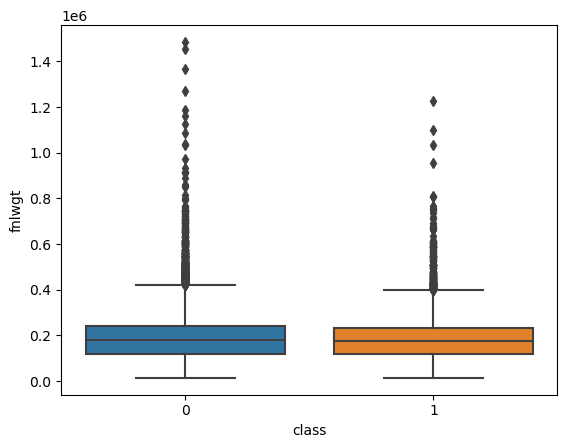

In [139]:
sns.boxplot(data = adult_df,x = 'class',y = 'fnlwgt')
plt.show()

We observe that the boxplots for both classes of the target feature about the data distribution of fnlwgt did not exhibit any discernible differences with regard to the association between features fnlwgt and income. this might mean that this feature is not usefult for the model 

In [140]:
# Checking point biserial correlation for relation between numerical variables and class variables

# independant Feature names
# categorical
categorical_columns = adult_df.loc[:, adult_df.dtypes == object].columns
# numerical
numerical_columns = adult_df.loc[:, adult_df.dtypes != object].drop(columns=['class']).columns

for i in numerical_columns:
    print(i,'-->',round(st.pointbiserialr(adult_df['class'],adult_df[i])[0],6))

age --> 0.242431
fnlwgt --> -0.009446
capital-gain --> 0.221871
capital-loss --> 0.151461
hours-per-week --> 0.228547


In [141]:
# Fnlwgt has the least correlation hence we can drop the column
_list = ['fnlwgt']
adult_df,adult_df_test = drop_cols(adult_df,adult_df_test,_list)

 Shape Before: Train: (30718, 13), Test:(15315, 13)
 Shape After: Train: (30718, 12), Test:(15315, 12)


<hr style="border:3px solid black">

**The remaining numeric variables, although are numeric but are finite in numbers hence we opt to convert them to categories**

In [142]:
# Age although in numeric variable has limited values
adult_df['age'].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 33, 76, 55, 61, 70, 64, 71, 66, 51, 58, 26, 17, 60,
       90, 75, 65, 77, 62, 63, 67, 74, 72, 69, 68, 73, 81, 78, 88, 80, 84,
       83, 85, 82, 86])

In [143]:
print("Minimum age: {}\nMaximum age: {}\nMean age: {}\nMedian age:{}".format(
     min(adult_df['age']), max(adult_df['age']), np.mean(adult_df['age']), np.median(adult_df['age'])))

Minimum age: 17
Maximum age: 90
Mean age: 38.44358356663845
Median age:37.0


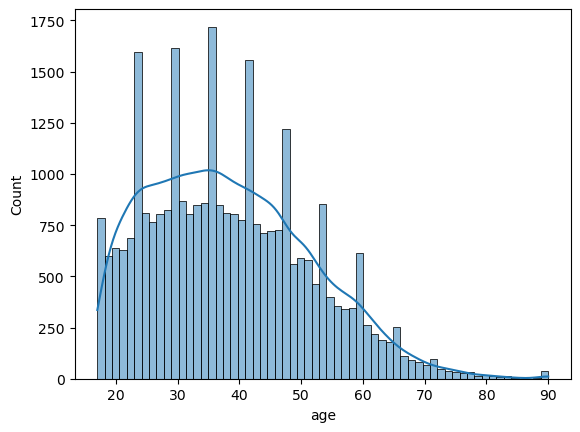

In [144]:
sns.histplot(data = adult_df,x = 'age', kde=True)
plt.show()

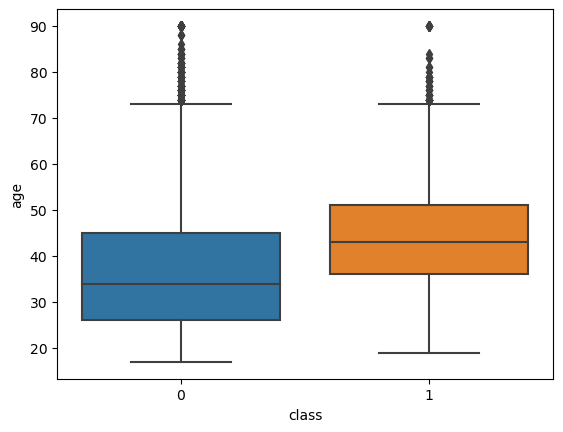

In [145]:
sns.boxplot(data = adult_df,x = 'class',y = 'age')
plt.show()

In [146]:
# So we can create age numbered categories (nominal)
# age<=25 = 0
# 25<age<=35 = 1 ...
#....
# 85<age<=95 = 7
# ___________

def convert_age(df):
    df.loc[(df['age']<=25),'age'] = 0      
    df.loc[(df['age']>25) & 
           (df['age']<=35), 'age'] = 1
    df.loc[(df['age']>35) & 
           (df['age']<=45), 'age'] = 2
    df.loc[(df['age']>45) & 
           (df['age']<=55), 'age'] = 3
    df.loc[(df['age']>55) & 
           (df['age']<=65), 'age'] = 4
    df.loc[(df['age']>65) & 
           (df['age']<=75), 'age'] = 5
    df.loc[(df['age']>75) & 
           (df['age']<=85), 'age'] = 6
    df.loc[(df['age']>85) & 
           (df['age']<=95), 'age'] = 7
    
    return df.astype({'age': 'object'})

adult_df = convert_age(adult_df)
adult_df_test = convert_age(adult_df_test)

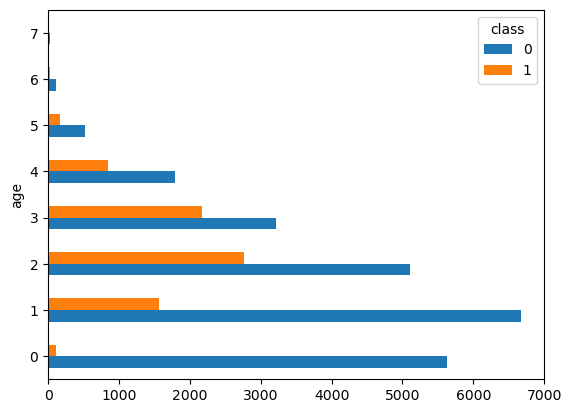

In [147]:
#  After creating age category
class_plot(adult_df,'age').show()

- Uneven data distribution with a higher concentration of participants between the ages of 20 and 50.

- In terms of the relationship between ages and earnings, we observe that older persons typically earn over $50,000 annually, whilst younger people typically earn less than $50,000.

- The boxplots do cross, though, and we can see that some older persons earn less per year than younger people and vice versa. It demonstrates how other aspects of the issue are relevant.



<hr style="border:3px solid black">

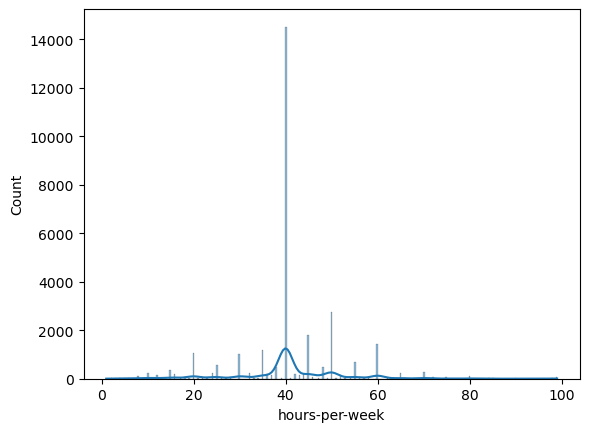

In [148]:
# hours-per-week
sns.histplot(data = adult_df,x = 'hours-per-week', kde=True)
plt.show()

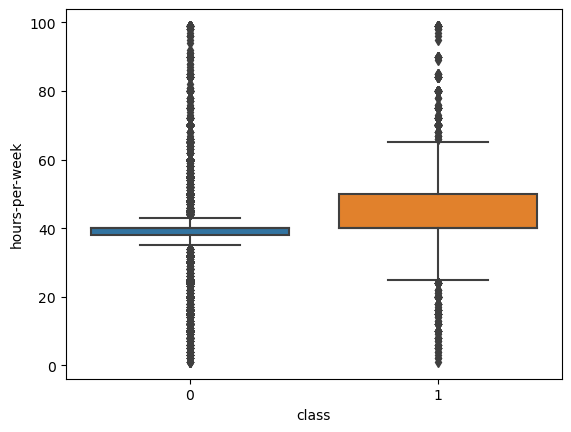

In [149]:
sns.boxplot(data = adult_df,x = 'class',y = 'hours-per-week')
plt.show()

In [150]:
print("Minimum hours-per-week: {}\nMaximum hours-per-week: {}\nMean hours-per-week: {}\nMedian hours-per-week:{}".format(
     min(adult_df['hours-per-week']), max(adult_df['hours-per-week']), np.mean(adult_df['hours-per-week']), np.median(adult_df['hours-per-week'])))

Minimum hours-per-week: 1
Maximum hours-per-week: 99
Mean hours-per-week: 40.94931310632202
Median hours-per-week:40.0


In [151]:
# hours-per-week also has few values and can be categorized
adult_df['hours-per-week'].unique()

array([40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 38, 43, 55,
       48, 58, 32, 70, 22, 56, 41, 28, 36, 24, 46,  2, 42, 12, 65,  1, 34,
       75, 98, 33, 54, 10,  6, 64, 19, 18, 72,  8,  9, 47, 37, 21, 26, 14,
        5, 59,  7, 99, 53, 39, 62, 57, 78, 90, 66, 11, 49, 84,  4, 17, 68,
        3, 27, 85, 31, 51, 77, 63, 23, 87, 88, 73, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95])

In [152]:
# Similar categorization can be done as seen in age
# 10 categories (nominal)
def convert_hours(df):
    df.loc[(df['hours-per-week']<=10),'hours-per-week'] = 0      
    df.loc[(df['hours-per-week']>10) & 
           (df['hours-per-week']<=20), 'hours-per-week'] = 1
    df.loc[(df['hours-per-week']>20) & 
           (df['hours-per-week']<=30), 'hours-per-week'] = 2
    df.loc[(df['hours-per-week']>30) & 
           (df['hours-per-week']<=40), 'hours-per-week'] = 3
    df.loc[(df['hours-per-week']>40) & 
           (df['hours-per-week']<=50), 'hours-per-week'] = 4
    df.loc[(df['hours-per-week']>50) & 
           (df['hours-per-week']<=60), 'hours-per-week'] = 5
    df.loc[(df['hours-per-week']>60) & 
           (df['hours-per-week']<=70), 'hours-per-week'] = 6
    df.loc[(df['hours-per-week']>70) & 
           (df['hours-per-week']<=80), 'hours-per-week'] = 7
    df.loc[(df['hours-per-week']>80) & 
           (df['hours-per-week']<=90), 'hours-per-week'] = 8
    df.loc[(df['hours-per-week']>90) & 
           (df['hours-per-week']<=100), 'hours-per-week'] = 9
    
    return df.astype({'hours-per-week': 'object'})

adult_df = convert_hours(adult_df)
adult_df_test = convert_hours(adult_df_test)

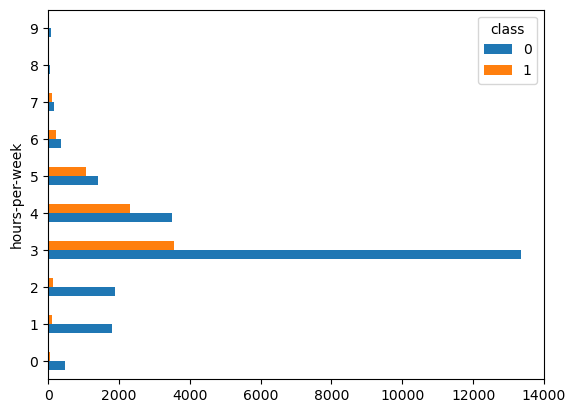

In [153]:
#  After creating hours-per-week category
class_plot(adult_df,'hours-per-week').show()

- Data distribution is out of proportion, with a higher number of those working between 40 and 50 hours per week.

- In terms of the association between weekly working hours and annual income, we observe that those who work more hours per week typically earn more per year.

- However, there are instances where people work more hours per week and make less or the same amount per year, and the opposite is also true.


<hr style="border:3px solid black">

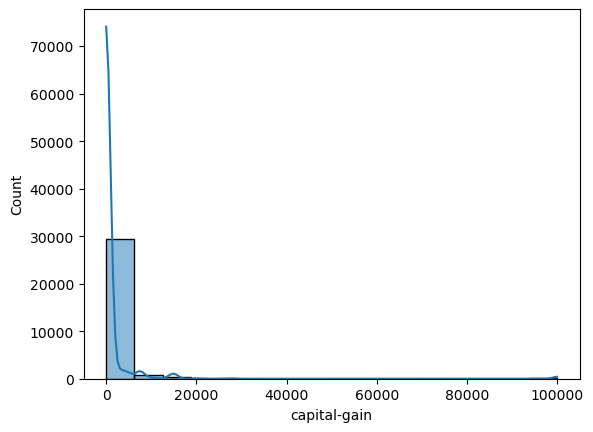

In [154]:
# capital-gain
sns.histplot(data = adult_df,x = 'capital-gain', kde=True)
plt.show()

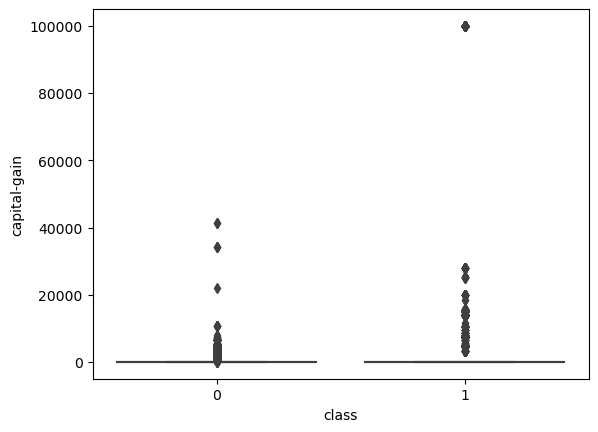

In [155]:
sns.boxplot(data = adult_df,x = 'class',y = 'capital-gain')
plt.show()

- There is an outlier with capital gain which can be seen in above figure.

- We observe that the boxplots for both classes of the goal feature regarding the data distribution of capital-gain did not reveal any discernible variances, which is relevant to the relationship between capital gain and yearly income.

- balanced data distribution, with a higher population concentration and no capital gain.

- There is an outlier with capital gain which can be seen in above figure.

In [156]:
print("Minimum capital-gain: {}\nMaximum capital-gain: {}\nMean capital-gain: {}\nMedian capital-gain:{}".format(
     min(adult_df['capital-gain']), max(adult_df['capital-gain']), np.mean(adult_df['capital-gain']), np.median(adult_df['capital-gain'])))

Minimum capital-gain: 0
Maximum capital-gain: 99999
Mean capital-gain: 1106.0370792369295
Median capital-gain:0.0


In [157]:
len(adult_df['capital-gain'].unique())

118

In [158]:
# There are 155 values for capital-gain with 99999
adult_df['capital-gain'].value_counts()

0        28129
15024      343
7688       278
7298       244
99999      155
         ...  
6097         1
2538         1
401          1
1455         1
1086         1
Name: capital-gain, Length: 118, dtype: int64

In [159]:
# second max value
adult_df['capital-gain'].nlargest(156)

1246     99999
1368     99999
1482     99999
1528     99999
1616     99999
         ...  
31972    99999
32090    99999
32238    99999
32518    99999
6433     41310
Name: capital-gain, Length: 156, dtype: int64

In [160]:
adult_df_test['capital-gain'].value_counts()

0        14043
15024      165
7688       124
7298       114
99999       84
         ...  
2329         1
3273         1
2346         1
34095        1
2036         1
Name: capital-gain, Length: 111, dtype: int64

In [161]:
# second max value
adult_df_test['capital-gain'].nlargest(85)

83       99999
346      99999
357      99999
418      99999
692      99999
         ...  
16021    99999
16030    99999
16037    99999
16068    99999
3605     41310
Name: capital-gain, Length: 85, dtype: int64

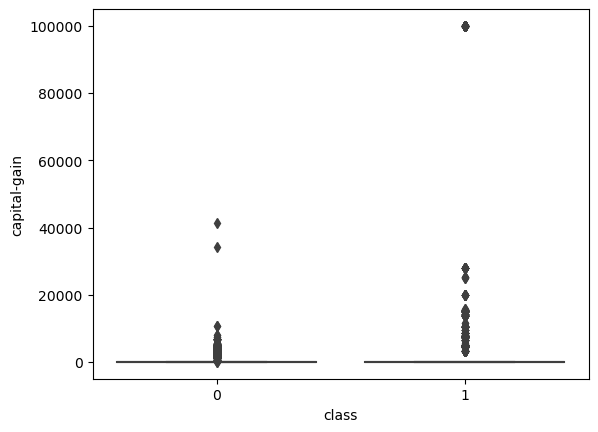

In [162]:
sns.boxplot(data = adult_df_test,x = 'class',y = 'capital-gain')
plt.show()

**With Capital loss we can see an outlier value of 99999 in both train and test set with second max value of 41310. There are two options, either delete these entries with 99999 or include them in a category of above 50000. We choose to include them**

In [163]:
# Categorising the Capital Gains
def convert_gain(df):
    df.loc[(df['capital-gain']<=10000),'capital-gain'] = 0      
    df.loc[(df['capital-gain']>10000) & 
           (df['capital-gain']<=20000), 'capital-gain'] = 1
    df.loc[(df['capital-gain']>20000) & 
           (df['capital-gain']<=30000), 'capital-gain'] = 2
    df.loc[(df['capital-gain']>30000) & 
           (df['capital-gain']<=40000), 'capital-gain'] = 3
    df.loc[(df['capital-gain']>40000) & 
           (df['capital-gain']<=50000), 'capital-gain'] = 4
    df.loc[(df['capital-gain']>50000) , 'capital-gain'] = 5
   
    return df.astype({'capital-gain': 'object'})

adult_df = convert_gain(adult_df)
adult_df_test = convert_gain(adult_df_test)

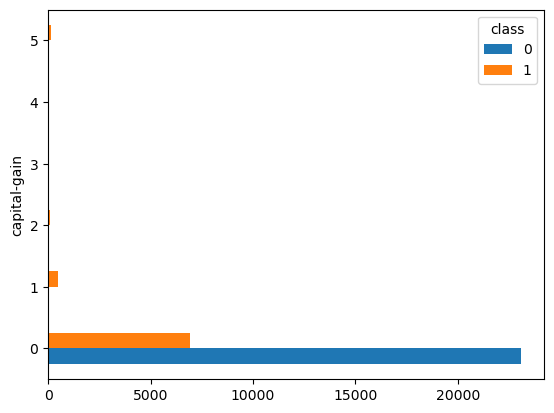

In [164]:
# maximum values are in 0 category because maximum have 0 values (check above)
class_plot(adult_df,'capital-gain').show()

<hr style="border:3px solid black">

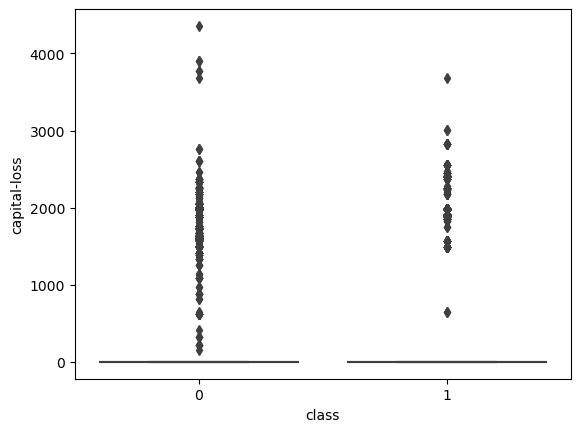

In [165]:
# capital-loss
sns.boxplot(data = adult_df,x = 'class',y = 'capital-loss')
plt.show()

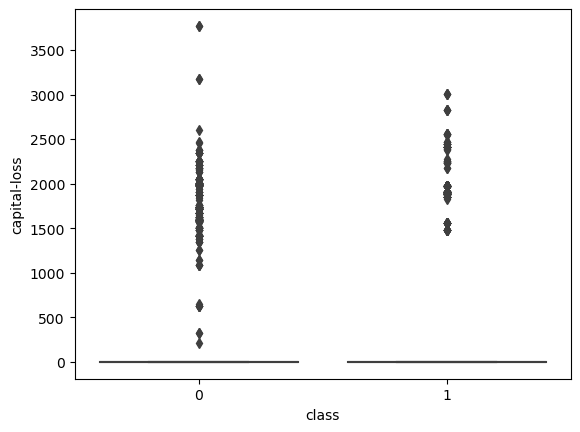

In [166]:
sns.boxplot(data = adult_df_test,x = 'class',y = 'capital-loss')
plt.show()

In [167]:
print("Minimum capital-loss: {}\nMaximum capital-loss: {}\nMean capital-loss: {}\nMedian capital-loss:{}".format(
     min(adult_df['capital-loss']), max(adult_df['capital-loss']), np.mean(adult_df['capital-loss']), np.median(adult_df['capital-loss'])))

Minimum capital-loss: 0
Maximum capital-loss: 4356
Mean capital-loss: 88.91021550882219
Median capital-loss:0.0


In [168]:
adult_df['capital-loss'].unique()

array([   0, 2042, 1408, 1902, 1573, 1887, 1719, 1762, 1564, 2179, 1816,
       1980, 1977, 1876, 1340, 2206, 1741, 1485, 2339, 2415, 1380, 1721,
       2051, 2377, 1669, 2352, 1672,  653, 2392, 1504, 1590, 1651, 1628,
       1848, 2001, 1740, 2002, 1579, 2258, 1602, 2547, 2205, 1726, 2444,
       1138, 2238,  625,  213, 1539,  880, 1668, 1092, 1594, 3004, 2231,
       1844,  810, 2824, 2559, 2057, 1974,  974, 2174, 2149, 1735, 1258,
       2129, 2603, 2282,  323, 2246, 1617, 1648, 1825, 3770, 1755, 3683,
       4356, 2267, 2080, 2457,  419,  155, 3900, 2201, 1944, 2467, 2754,
       2472, 1411])

In [169]:
len(adult_df['capital-loss'].unique())

90

In [170]:
# Similar to capital-gain, categorising the Capital Loss
def convert_loss(df):
    df.loc[(df['capital-loss']<=500),'capital-loss'] = 0 
    df.loc[(df['capital-loss']>500) & 
           (df['capital-loss']<=1000), 'capital-loss'] = 1
    df.loc[(df['capital-loss']>1000) & 
           (df['capital-loss']<=1500), 'capital-loss'] = 2
    df.loc[(df['capital-loss']>1500) & 
           (df['capital-loss']<=2000), 'capital-loss'] = 3
    df.loc[(df['capital-loss']>2000) & 
           (df['capital-loss']<=2500), 'capital-loss'] = 4
    df.loc[(df['capital-loss']>2500) & 
           (df['capital-loss']<=3000), 'capital-loss'] = 5
    df.loc[(df['capital-loss']>3000) & 
           (df['capital-loss']<=3500), 'capital-loss'] = 6
    df.loc[(df['capital-loss']>3500) & 
           (df['capital-loss']<=4000), 'capital-loss'] = 7
    df.loc[(df['capital-loss']>4000) & 
           (df['capital-loss']<=4500), 'capital-loss'] = 8
    df.loc[(df['capital-loss']>4500) & 
           (df['capital-loss']<=5000), 'capital-loss'] = 9
    df.loc[(df['capital-loss']>5000) , 'capital-loss'] = 10
   
    return df.astype({'capital-loss': 'object'})

adult_df = convert_loss(adult_df)
adult_df_test = convert_loss(adult_df_test)

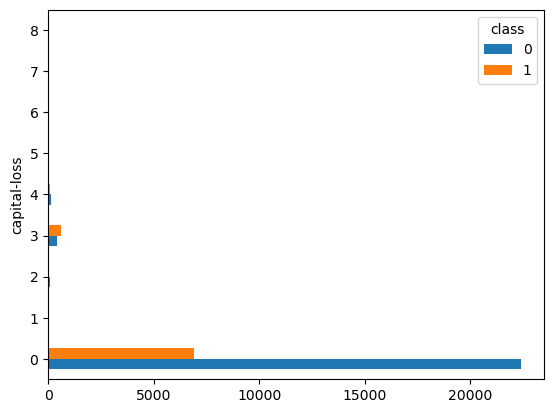

In [171]:
class_plot(adult_df,'capital-loss').show()

In [172]:
# set(adult_df_test['capital-loss'].unique()).difference(set(adult_df['capital-loss'].unique()))

**As we can see capital-loss and capital-gain both had numerical values but finite in number so hence made categorical**

<hr style="border:3px solid black">

In [173]:
adult_df = adult_df.astype({'class':'object'})
adult_df_test = adult_df_test.astype({'class':'object'})

In [174]:
# All  variables are set to categorical, 
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30718 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30718 non-null  object
 1   workclass       30718 non-null  object
 2   education-num   30718 non-null  object
 3   marital-status  30718 non-null  object
 4   occupation      30718 non-null  object
 5   relationship    30718 non-null  object
 6   race            30718 non-null  object
 7   sex             30718 non-null  object
 8   capital-gain    30718 non-null  object
 9   capital-loss    30718 non-null  object
 10  hours-per-week  30718 non-null  object
 11  class           30718 non-null  object
dtypes: object(12)
memory usage: 4.1+ MB


In [175]:
adult_df.head(5)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,class
0,2,Gov,2,Single,Adm-clerical,Not-in-family,White,Male,0,0,3,0
1,3,Non-Gov,2,Married,Exec-managerial,Husband,White,Male,0,0,1,0
2,2,Non-Gov,1,Single,Handlers-cleaners,Not-in-family,White,Male,0,0,3,0
3,3,Non-Gov,1,Married,Handlers-cleaners,Husband,Non-White,Male,0,0,3,0
4,1,Non-Gov,2,Married,Prof-specialty,Wife,Non-White,Female,0,0,3,0


Can be further explored for more information
<hr style="border:3px solid black">

In [177]:
# Method to get the Independent features X and target column Y of train and test
def train_test_split(df, df_test):
    X_train = df.drop(columns=['class'])
    y_train = df['class']
    X_test = df_test.drop(columns=['class'])
    y_test = df_test['class']
    
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = train_test_split(adult_df,adult_df_test)

In [178]:
# Copies of our necessary variables
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

X_test_copy = X_test.copy()
y_test_copy = y_test.copy()

<hr style="border:3px solid black">

## Checking Feature Importance

Ref URL: https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [180]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder

X = X_train_copy.copy()
y = y_train_copy.copy()

X_t = X_test_copy.copy()
y_t = y_test_copy.copy()

# ordinal encoding the categorical variables
encoder = OrdinalEncoder()
X = encoder.fit_transform(X)
X_t = encoder.transform(X_t)

# Label encoding class label
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

# Get the variable/feature names later used for plotting
cols = X_train.columns

#### Chi-Square feature selection test - check importance of feature

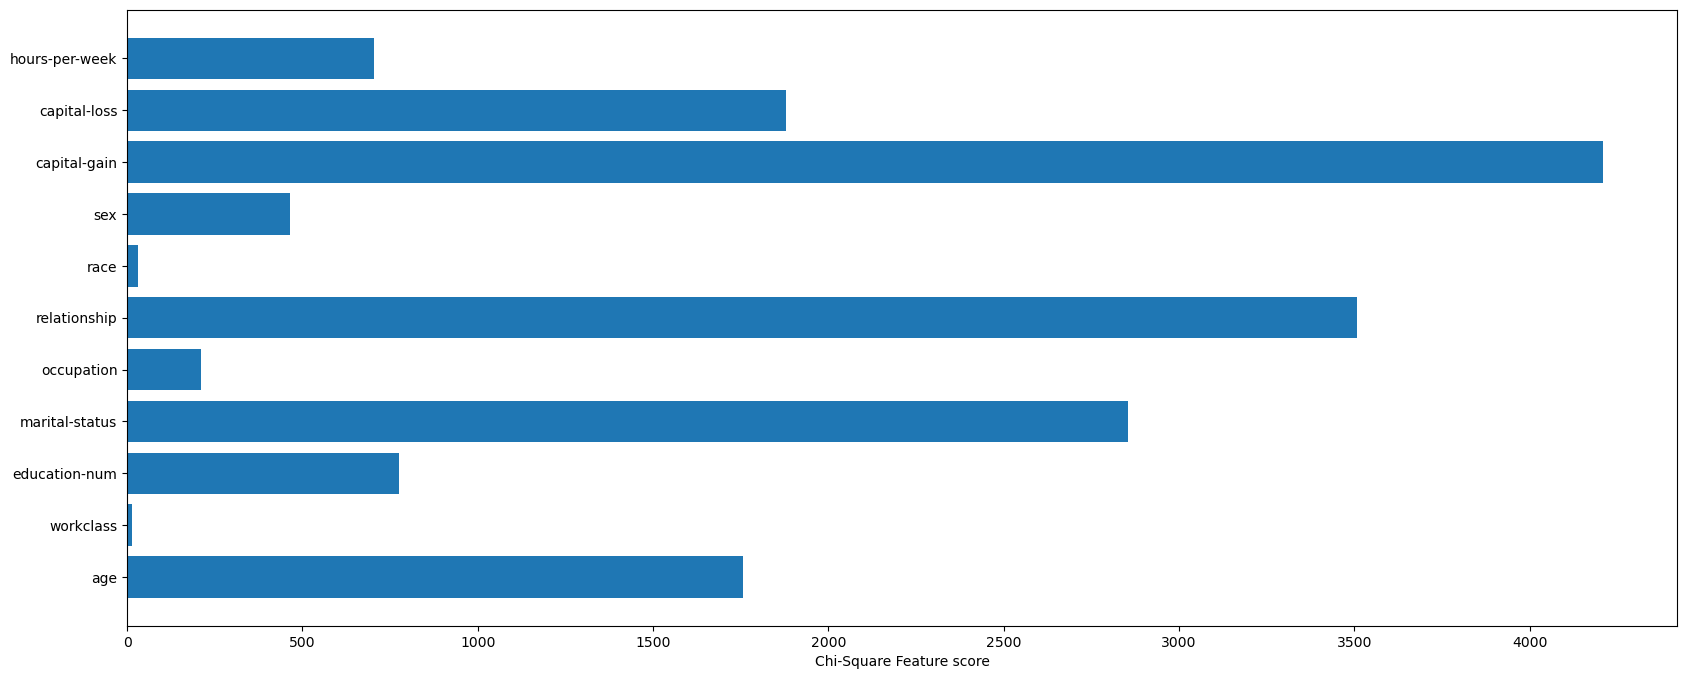

In [181]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def c_test(X_train,y_train):
    # Fit & Transform
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    
    # what are scores for the features
    # for i in range(len(fs.scores_)): print('Feature %s: %f' % (cols[i], fs.scores_[i]))
        
    plt.figure(figsize = (20,8))
    # plot the scores
    plt.barh([i for i in cols],fs.scores_)
    plt.xlabel("Chi-Square Feature score")
    plt.savefig('chisq.png')
    plt.show()
c_test(X,y)

#### Plotting the feature importances using the Random Forrest Regressor

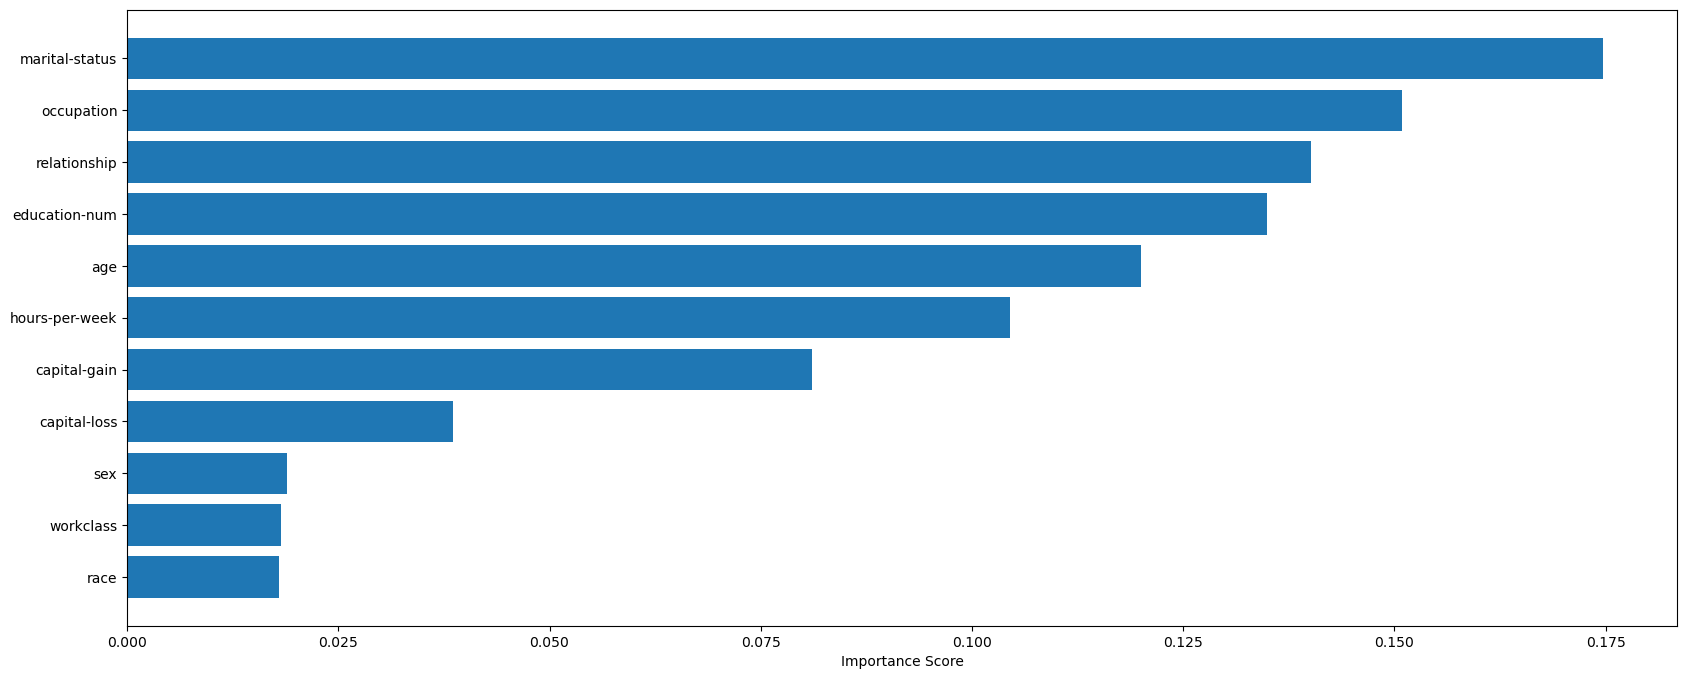

In [182]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
#for i,v in enumerate(importance):
     #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize = (20,8))
# plot the scores
d = {cols[i]:importance[i] for i in range(len(cols))}
d = sorted(d.items(), key=lambda x:x[1])
plt.barh([i[0] for i in d],[i[1] for i in d])
plt.xlabel("Importance Score")
plt.show()

#### Plotting the feature importances using the Decision Tree Classifier

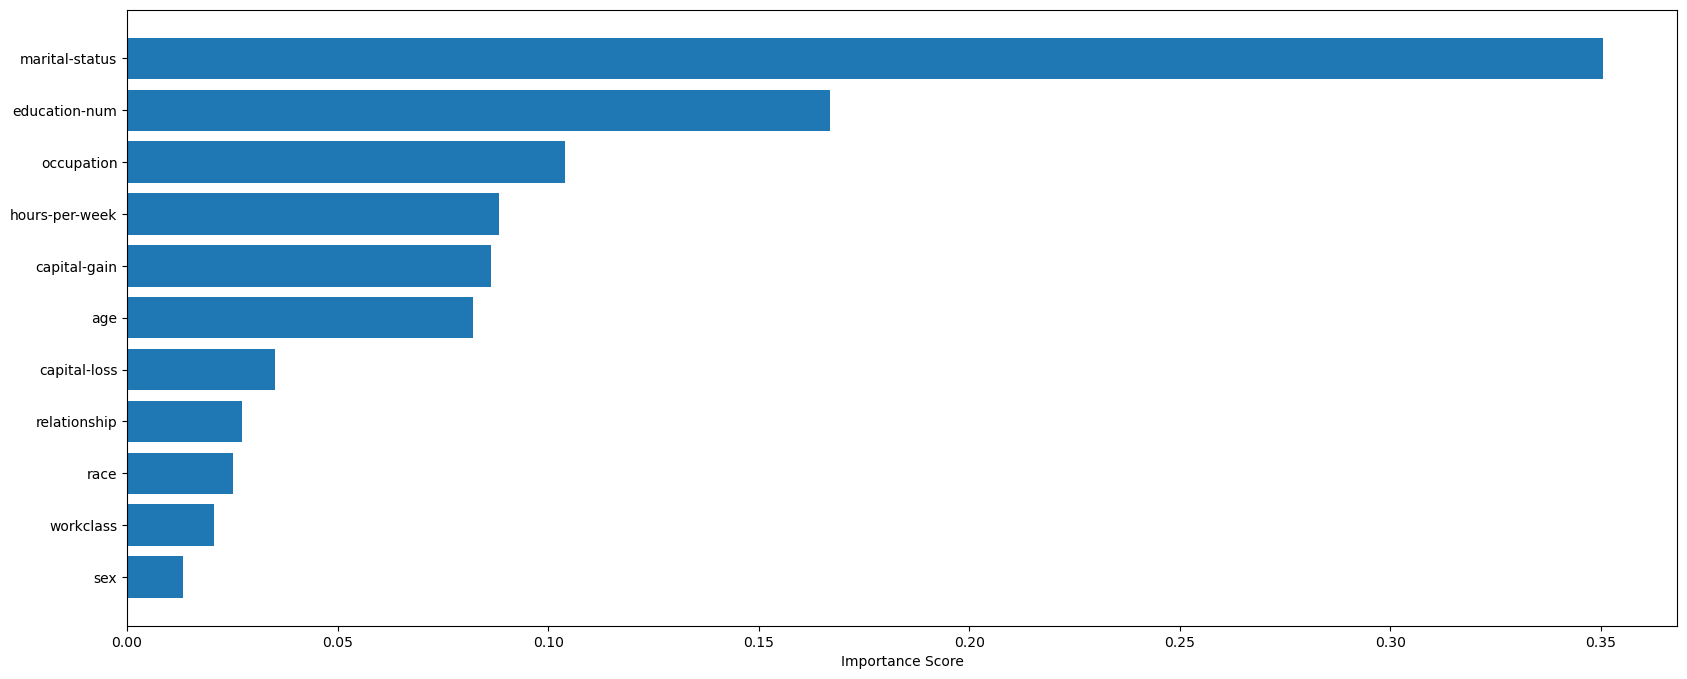

In [183]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# plot feature importance
plt.figure(figsize = (20,8))
# plot the scores
d = {cols[i]:importance[i] for i in range(len(cols))}
d = sorted(d.items(), key=lambda x:x[1])
plt.barh([i[0] for i in d],[i[1] for i in d])
plt.xlabel("Importance Score")
plt.show()

**Based on the above 3 feature importance tests, 3 common features with least importance are sex, race and workclass so we can remove these un-important features for our modeling purpose. Note that we have tried modelling using all the features present as well as removing these 3 least import features ahead**

In [185]:
adult_df.head(2)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,class
0,2,Gov,2,Single,Adm-clerical,Not-in-family,White,Male,0,0,3,0
1,3,Non-Gov,2,Married,Exec-managerial,Husband,White,Male,0,0,1,0


<hr style="border:3px solid black">

## ML Modelling

In [187]:
# Libraries for Modelling
# Note that not all libraries used but were imported incase of future usage.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, TimeDistributed
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import backend as k
from tensorflow.keras.layers import GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, LSTM, GRU, Bidirectional, Input
import random
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [188]:
#Uncomment to install
# !pip3 install imbalanced-learn

#### Modelling Pipeline (Method overview) - 
Once our data was ready, for applying ML models, we created a method pipeline with several functions and flags, which allowed us to execute multiple models based on out choices. Following are the methods/functions used:-
- **train_test_oversample**
    - The method performs SMOTE oversampling which can be used on our data set
    - takes two parameters the independent features X, and target feature Y and returns the oversampled X and Y.
- **train_test_randomoversample**
    - The method performs Random oversampling with minority sample strategy, which can be used on our data set
    - takes two parameters the independent features X, and target feature Y and returns the oversampled X and Y.
- **prep**
    - The method prepared the data for our models i.e one hot encode the target variable Y, and dummy encode the independant variables X
    - Allows us to either use oversampled or non oversampled data (by calling either one of the oversampling methods based on a flag)
    - Allows us to either choose the entire data set or data after removing the least important features - sex, race and workclass.
    - returns X_train, y_train, X_test, y_test
- **plot_history**
    - Plotting the neural network models train and validation loss and accuracy curves
- **plot_roc_auc**
    - Plotting the ROC curve (along with same curve zoomed in the left corner)
- **score**
    - Takes y_test and predicted output classes and provided evaluation scores
    - Scores include Accuracy, AUC, precission, Recall, F1 along with classification report
    - Also plots the confusion matrix
- **predict_acc**
    - Taked the fit model as input along with the test data, and predicts the output classes.
    - calls score
    - calls plot_roc_auc
    - calculates threshold based on youden's J Statistic
    - calls score to display the new updated results
- **Model Functions (model_1, model_2..)**
    - these methods are the core where the model architecture is created
    - Several models were created to test optimal output
    - models mainly included either multiple layers of deep fully connected neural networks (dense) or combination of dense and Convolutional neural networks (CNN)
    - dropouts layers which nullifies contributions of few neurons were used to prevent overfitting
    - sigmoid activation function along with binary crossentropy for loss evaluation were used as our problem was binary classification
    - model was compiled using the training set for different batch sizes and validation splits
    - calls plot_history and returns the fit model for prediction
- **execute**
    - The main method to execute the model and get the results
    - takes the *Model Functions/Methods* along with the relevant flags
    - calls prep
        - If model in CNN, reshapes the prepared data for input to 1d convolution layer
    - calls the model funtion by passing the train data
    - calls the predict_acc by passing the compiled model to get the results
    - makes shap plots to find the input variables which is most affecting the results.

In [189]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# SMOTE Oversampling, return the oversamples X and y
def train_test_oversample(X,y):
    print('==========SMOTE Over Sampling=============')
    # define oversampling strategy
    oversample = SMOTE()
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    # summarize class distribution
    print(Counter(y_over))
    print('=================')
    return X_over,y_over

# Random Oversampling, return the oversamples X and y
def train_test_randomoversample(X,y):
    print('==========RANDOM Over Sampling=============')
    # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy='minority')
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    # summarize class distribution
    print(Counter(y_over))
    print('=================')
    return X_over,y_over

In [190]:

# Prepare data for modelling
def prep(useAllFeatures = True, oversample = False, isRandom = False):
    
    # Using Full Features
    if(useAllFeatures):
        X_train,y_train,X_test,y_test = train_test_split(adult_df,adult_df_test)
    else:
        _list = ['race','sex','workclass']
        adult_df_new,adult_df_test_new = drop_cols(adult_df,adult_df_test,_list)

        X_train,y_train,X_test,y_test = train_test_split(adult_df_new,adult_df_test_new)
    
    
    # Preparing X
    print("========Preparing X==========")
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    print("Getting Dummies")

    # one hot encoding
    # Getting the dummy variables for categorical iputs
    X_train = pd.get_dummies(X_train, drop_first = True)
    X_test = pd.get_dummies(X_test, drop_first = True)

    # Columns missing due to capital loss/gain categorical dummy variable
    # Get missing columns in the training test
    missing_cols = set( X_train.columns ) - set( X_test.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        X_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    X_test = X_test[X_train.columns]

    print(X_train.shape, X_test.shape)
    
    # Preparing Y
    print("========Preparing Y==========")
    # Coding training class label
    y_le = LabelEncoder()
    # y_le.fit(y_train)
    y_train = y_le.fit_transform(y_train)
    y_test = y_le.transform(y_test)
    
    if oversample:
        if isRandom:
            X_train,y_train = train_test_randomoversample(X_train,y_train)
        else:
            X_train,y_train = train_test_oversample(X_train,y_train)
    
    # Before Using Neural networks, it is require to convert the target class vector 
    # to a binary matrix
    y_train = to_categorical(y_train, 2)
    print('Label: ', y_train.shape)
    
            
    return X_train,y_train,X_test,y_test

In [191]:
# Plot model train-validation accurary and loss curves
def plot_history(history,name="fig"):
    print("|="*200)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.savefig(name+'png')
    return plt;

In [192]:
# Plot ROC curve
def plot_roc_auc(fpr_rf, tpr_rf, thresholds_rf,auc_rf):
    plt.figure(1)
    plt.plot(fpr_rf, tpr_rf, label='(area = {:.3f})'.format(auc_rf))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(2)
    plt.xlim(0, 0.5)
    plt.ylim(0.5, 1)
    plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()
    return;

In [193]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Prints all the evaluation scores along with confusion matrix
def score(y_test, y_classes):
    print("="*100)
    print("Accuracy Score: ",accuracy_score(y_true=y_test, y_pred=y_classes))
    print("Precision: ", precision_score(y_test, y_classes))
    print("Recall: ", recall_score(y_test, y_classes))
    print("F1: ", f1_score(y_test, y_classes))
    print("AUC: ", roc_auc_score(y_test, y_classes))
    print("="*100)
    print(classification_report(y_test, y_classes))
    print("="*100)
    cm = confusion_matrix(y_true=y_test, y_pred=y_classes)
    #display_labels=model.classes_
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    
def calc_threshold(y_prob):
    pass


# Predic output labels and get the score
def predict_acc(model,X_test,y_test):
    y_tst = model.predict(X_test)
    #y_prob = model.predict_proba(X_test)
    y_prob = y_tst
    y_classes = y_tst.argmax(axis=-1)
    #y_classes = y_le.inverse_transform(y_classes)
   
    # Getting the scores 
    score(y_test, y_classes)
    
    # Get the threshold using Youdens J statistic
    print("="*100)
    
    # display ROC_AUC
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob[:, 1])
    auc_rf = auc(fpr_rf, tpr_rf)
    plot_roc_auc(fpr_rf, tpr_rf, thresholds_rf,auc_rf)
    
    # Finding Optimal threshold
    print("|="*200)
    J = tpr_rf - fpr_rf
    ix = np.argmax(J)
    print("="*100)
    print('Best Threshold using Youdens J statistic =%f, J=%.3f' % (thresholds_rf[ix], J[ix]))
    threshold = thresholds_rf[ix]
    
    # finding classes based on optimal threshold
    print("="*100)
    y_class_opt = np.where(y_prob[:, 1] > threshold, 1, 0)
    
    print("==After applying Threshold==")
    score(y_test, y_class_opt)
    

In [194]:
import shap
# Execute the model and get the results
def execute(model_fun,useAllFeatures = True,isCNN=False, oversample = False, isRandom = False):
    print("|="*200)
    # Prepare data for the model
    X_train, y_train,X_test,y_test = prep(useAllFeatures, oversample, isRandom)
    
    # Reshape if model is cnn
    if isCNN==True:
        print("========RESHAPING=========")
        X_train = X_train.to_numpy().reshape(-1,X_train.shape[1],1)
        X_test = X_test.to_numpy().reshape(-1,X_train.shape[1],1)
        print("Shape train:",X_train.shape)
        print("Shape test:",X_test.shape)
    
    print("|="*200)

    # Using Tensor flow device for parallelisation
    with tf.device(SET_DEVICE):
        model = model_fun(X_train, y_train)
    print("|="*200)
    
    # Predict the class and display the results (scores, ROC plot and confusion matrix)
    predict_acc(model,X_test,y_test)
    print("|="*200)
    
    print("SHAP VALUES EXPLAINING MODEL:")
    explainer = shap.DeepExplainer(model, X_train.to_numpy())
    shap_values = explainer.shap_values(X_test.to_numpy())
    shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_train.columns)
    return shap_values
    

<hr style="border:3px solid black">

In [ ]:
def model_0(X_train, y_train):
    model = Sequential()
    model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='sigmoid'))
    plot_model(model, to_file='model_0.png')
    print("|="*200)
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.pre
    model.summary()
    print("|="*200)
    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=72,verbose=1, validation_split=0.25)
    # model.predict_proba
    plot_history(history).show()
    
    return model

<hr style="border:3px solid black">

In [196]:
def model_1(X_train, y_train):
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='sigmoid'))
    plot_model(model)
    print("|="*200)
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(lr=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.pre
    model.summary()
    print("|="*200)
    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32,verbose=1, validation_split=0.1)
    # model.predict_proba
    plot_history(history).show()
    
    return model

<hr style="border:3px solid black">

In [197]:
def model_2(X_train, y_train):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(2, activation='sigmoid'))
    plot_model(model)
    print("|="*200)
    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy'],
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    
    model.summary()
    print("|="*200)
        
    history = model.fit(X_train, y_train,
                        batch_size=50, epochs=30,
                        verbose=2,
                        validation_split=0.1)
        
    plot_history(history).show()
        
    return model


<hr style="border:3px solid black">

In [198]:
def model_3(X_train, y_train):
    # Define the CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    plot_model(model,to_file='model_CNN.png')
    print("|="*200)
    model.compile(
            loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5))
    
    model.summary()
    print("|="*200)

    history = model.fit(X_train, y_train,
                            batch_size=64, epochs=50,
                            verbose=2,
                            validation_split=0.1)

    plot_history(history).show()
        
    return model




<hr style="border:3px solid black">

In [199]:
def model_4(X_train, y_train):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=0.4))
    model.add(Dense(2, activation='sigmoid'))
    plot_model(model)
    print("|="*200)
    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy'],
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    
    model.summary()
    print("|="*200)
        
    history = model.fit(X_train, y_train,
                        batch_size=64, epochs=30,
                        verbose=2,
                        validation_split=0.2)
        
    plot_history(history).show()
        
    return model


<hr style="border:3px solid black">

|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=
 Shape Before: Train: (30718, 12), Test:(15315, 12)
 Shape After: Train: (30718, 9), Test:(15315, 9)
========Preparing X==========
(30718, 8) (30718,)
(15315, 8) (15315,)
Getting Dummies
(30718, 51) (15315, 51)
========Preparing Y==========
Label:  (30718, 2)
|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|

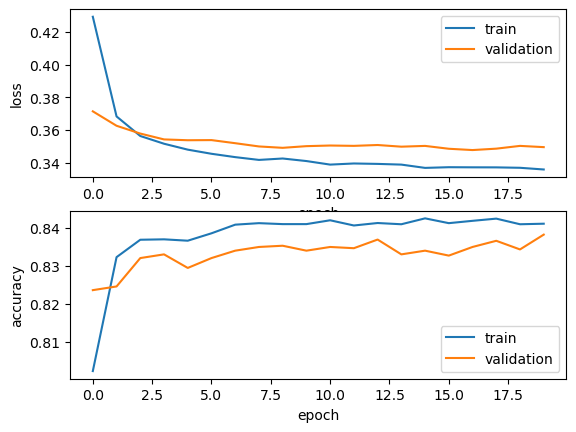

|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=
479/479 [==============================] - 1s 2ms/step
Accuracy Score:  0.841658504733921
Precision:  0.7328033183546492
Recall:  0.5620360551431601
F1:  0.63615903975994
AUC:  0.7475345310802001
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     11543
           1       0.73      0.56      0.64      3772

    accuracy                           0.84     15315
   macro avg       0.80      0.75      0.77     15315
weighted avg       0.83      0.84      0.83     15315



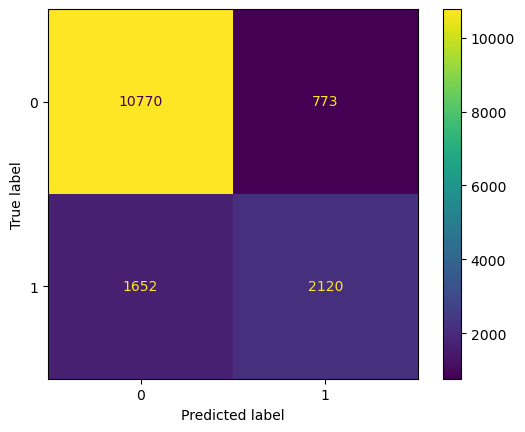

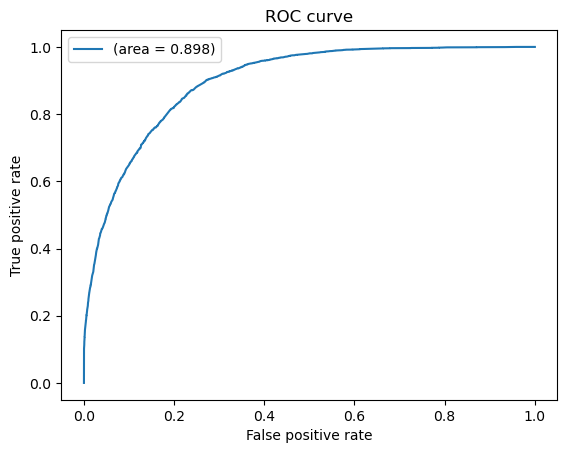

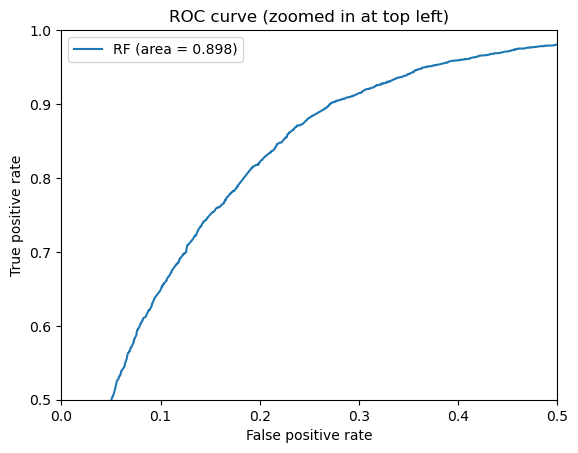

|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=
Best Threshold using Youdens J statistic =0.237276, J=0.634
==After applying Threshold==
Accuracy Score:  0.7892262487757101
Precision:  0.5451677183659913
Recall:  0.8703605514316013
F1:  0.6704104553808453
AUC:  0.816536942093692
              precision    recall  f1-score   support

           0       0.95      0.76      0.85     11543
           1       0.55      0.87      0.67      3772

    accuracy                           0.79     15315
   macro avg       0.75      0.82      0.76     15315
weighted avg       0.85      0.79      0.80     15315



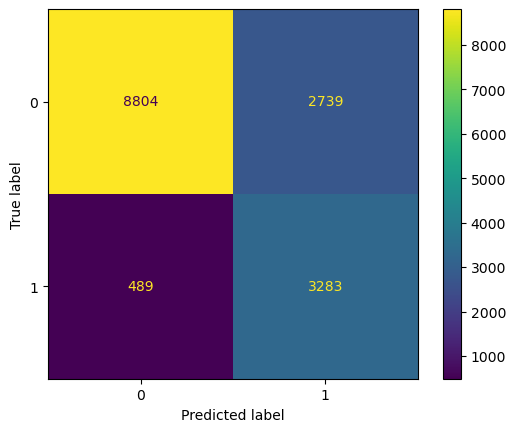

|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=|=
SHAP VALUES EXPLAINING MODEL:


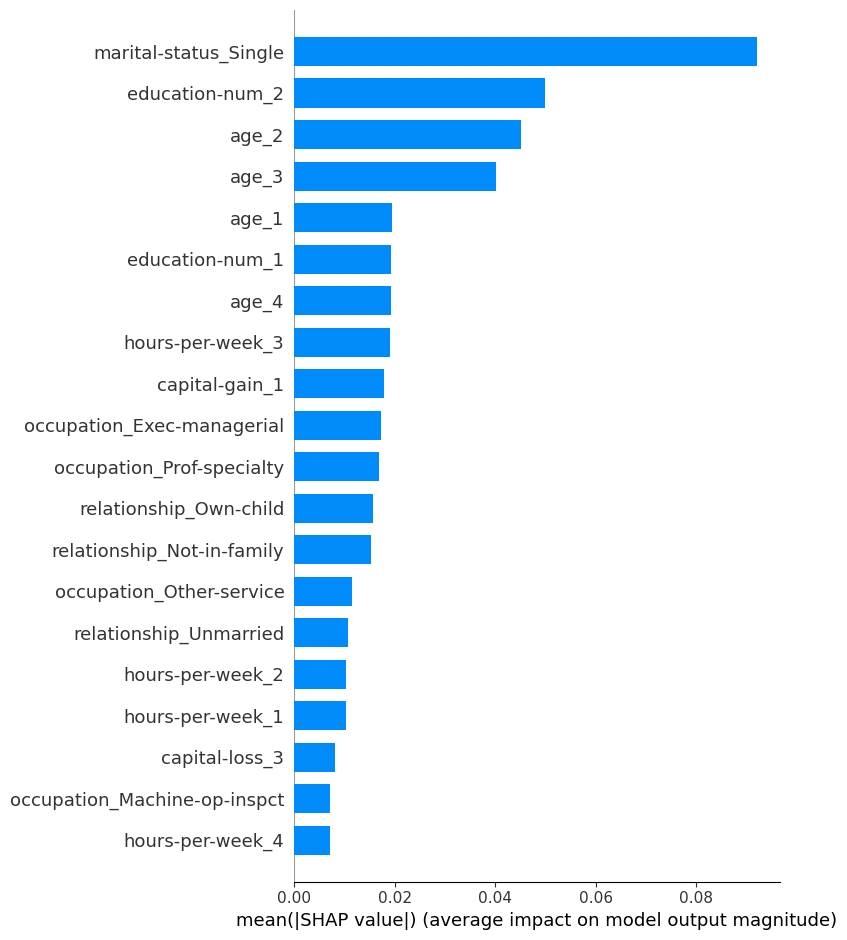

 Shape Before: Train: (30718, 12), Test:(15315, 12)
 Shape After: Train: (30718, 9), Test:(15315, 9)
========Preparing X==========
(30718, 8) (30718,)
(15315, 8) (15315,)
Getting Dummies
(30718, 51) (15315, 51)
========Preparing Y==========
Label:  (30718, 2)


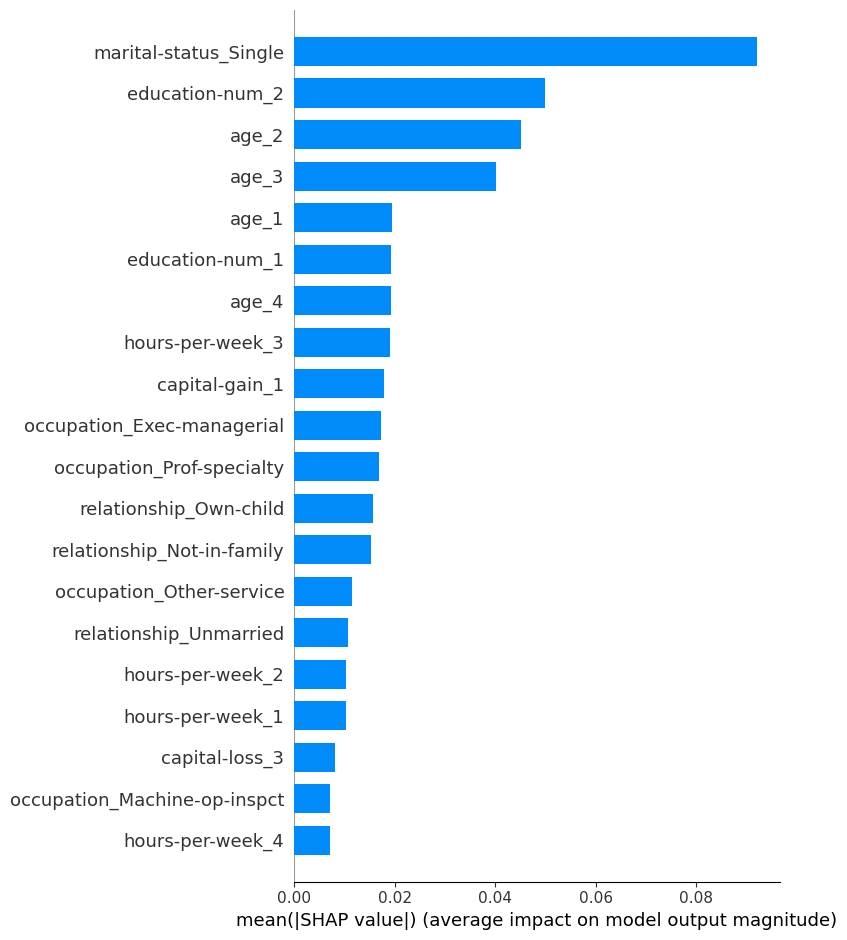

In [200]:
# Execution Model_1 (dense layers) and removing the ,least important features with no over sampling
shap_values = execute(model_1,False,False,False)
_, _,X_test,_ = prep(False, False, False)
shap.summary_plot(shap_values[0], plot_type = 'bar',feature_names = X_test.columns )

<hr style="border:3px solid black">

## Conclusion:

In conclusion, our experiment on adjusting the classification threshold has shown that it is possible to achieve a balance between correctly classifying individuals with income above \\$50,000 and those with income below \\$50,000.

By adjusting the classification threshold, we were able to improve the performance of our predictive model in terms of both precision and recall. This means that our model was able to correctly identify more individuals with income above \\$50,000 while still maintaining a relatively low number of false positives.

This is an important finding as it highlights the potential for predictive models to be adjusted to better suit the needs of specific applications. By finding the optimal threshold for our model, we were able to strike a balance between identifying as many high-income individuals as possible while minimizing the risk of misclassifying low-income individuals.

Overall, our results suggest that adjusting the classification threshold can be an effective way to optimize the performance of predictive models for specific applications, and can help to ensure that the models are both accurate and equitable in their predictions.

Additionally, the SHAP values analysis provides valuable insights into the factors that contribute to an individual's income level in the Adult census data. Our analysis has identified the top four factors that have the most significant impact on income level, namely marital status, education, age, and occupation.

Marital status was found to be the most important predictor of income, with unmarried/divorced/single individuals having a higher income than married individuals. Education level was also found to be a strong predictor of income, with higher levels of education associated with higher incomes. Age and occupation were also important predictors of income, with older individuals and individuals in certain occupations having higher incomes.

Overall, our analysis demonstrates the usefulness of the SHAP values method in interpreting predictive models and gaining insights into the factors that drive outcomes. These findings can be used to inform policy decisions and interventions aimed at addressing income inequality and promoting social and economic mobility.